In [1]:
import pandas as pd
import matplotlib
import numpy as np 
import seaborn as sns
# imports for gradient boosted trees
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import shap

df = pd.read_csv('data/analysisCSV/latest.csv')
df.drop(df.columns[[0,2]],axis=1,inplace= True)
df['time_series'] = df['year'] + df['month']/12
df = df.dropna(how='any',axis=0)
sdf = df.sample(n=1000,random_state=1)
df_sold = df.loc[df['sold']]

Now we will use time stamps to try to find correlations between listing information and the time that the watches are posted. 
- Questions
    - Has corona virus impacted watch sales and listings?
    - Does time of year affect watch listings?

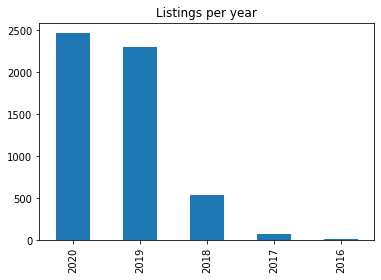

In [2]:
df['year'].value_counts().plot.bar(title="Listings per year")

Now we're going to look at data split into subsets based on year posted


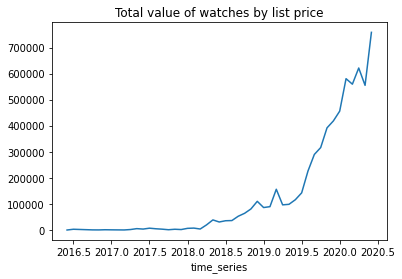

In [3]:
df.groupby(['time_series']).sum()['list_price'].plot.line(title = "Total value of watches by list price")

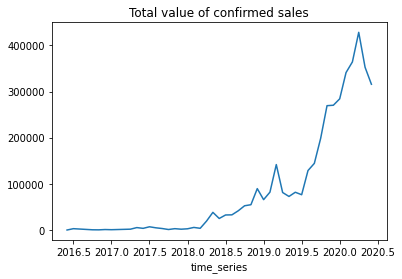

In [4]:
df_sold.groupby(['time_series']).sum()['list_price'].plot.line(title = "Total value of confirmed sales")

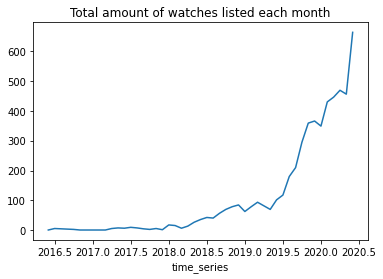

In [5]:
df.groupby(['time_series']).count()['list_price'].plot.line(title = "Total amount of watches listed each month")

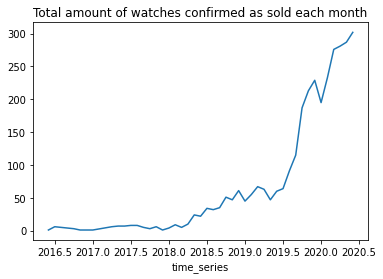

In [6]:
df_sold.groupby(['time_series']).count()['list_price'].plot.line(title = "Total amount of watches confirmed as sold each month")

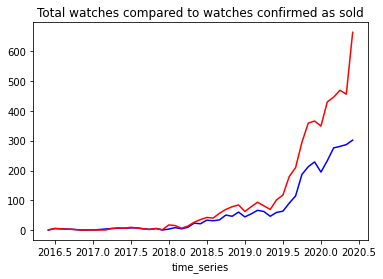

In [7]:
df_sold.groupby(['time_series']).count()['list_price'].plot.line(color = 'b')
df.groupby(['time_series']).count()['list_price'].plot.line(color = 'r',title='Total watches compared to watches confirmed as sold')

After looking at this I got the idea that I wanted to look at the probability that a watch will be sold as a function of how long the watch has been listed for 

In [8]:
a = df.groupby(['time_series']).count()['list_price']
b = df_sold.groupby(['time_series']).count()['list_price']
prob_sold = (a-b)/a
prob_sold = prob_sold.to_frame().reset_index()
prob_sold = prob_sold.rename(columns={'time':'time_series','prob':'list_price'})


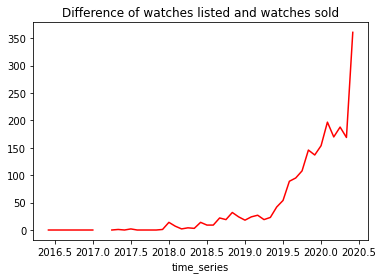

In [9]:
diff = df.groupby(['time_series']).count()['list_price'] - df_sold.groupby(['time_series']).count()['list_price']
diff.plot.line(title='Difference of watches listed and watches sold',color = 'r')

In [10]:
# Trying to fit a line to match the difference in watches sold vs watches listed
test = diff.to_frame().reset_index()
test['time_series'] = test['time_series'] - 2016
fitted = np.polyfit(test['time_series'],test['list_price'],2)
fitted

array([nan, nan, nan])

In the above two graphs we can see the drop off of watch sales as the difference between watches sold vs watches listed grows exponentially. No I want to see if this difference can be seen as starkly with seikos compared to rolexes. Two watches that are amongst the top 10 most popular watch brands on the subreddit despite both being in such different price rangers.

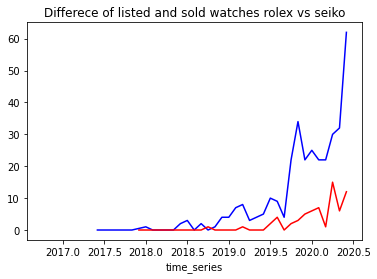

In [11]:
df_seiko = df.loc[df['seiko'] == 1]
df_seiko_sold = df_seiko.loc[df['sold']]
df_rolex = df.loc[df['rolex'] == 1]
df_rolex_sold = df_rolex.loc[df['sold']]
diff_seiko = df_seiko.groupby(['time_series']).count()['list_price'] - df_seiko_sold.groupby(['time_series']).count()['list_price']
diff_rolex = df_rolex.groupby(['time_series']).count()['list_price'] - df_rolex_sold.groupby(['time_series']).count()['list_price']
diff_seiko.plot.line(color = 'b',y = 'seiko')
diff_rolex.plot.line(color = 'r', title = "Differece of listed and sold watches rolex vs seiko", y = 'rolex')

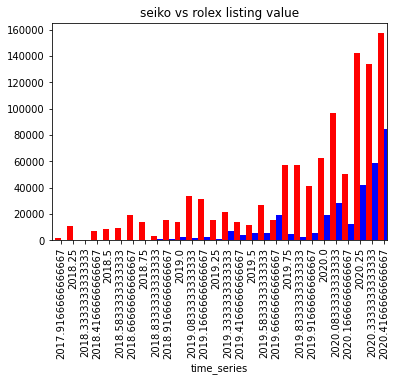

In [12]:
df_seiko.groupby(['time_series']).sum()['list_price'].plot(kind = 'bar',position = 0, color = 'b')
df_rolex.groupby(['time_series']).sum()['list_price'].plot(kind = 'bar',position = 1,color = 'r', title = "seiko vs rolex listing value")

In [13]:
df_rolex['list_price'].describe()

count      307.000000
mean      3498.964169
std       3370.542580
min          2.000000
25%       1925.000000
50%       2800.000000
75%       4187.500000
max      42500.000000
Name: list_price, dtype: float64

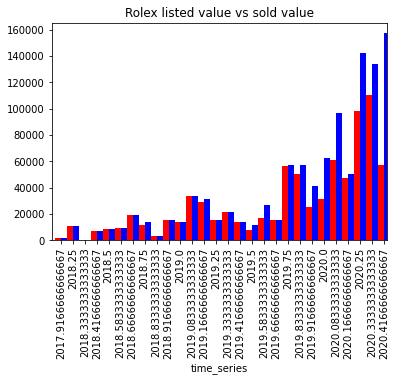

In [14]:
df_rolex.groupby(['time_series']).sum()['list_price'].plot(kind='bar',position=0,color='b')
df_rolex_sold.groupby(['time_series']).sum()['list_price'].plot(kind='bar',position=1,color='r',title='Rolex listed value vs sold value')

Below we are starting the machine learning!

In [28]:
y = df['sold']
X = df.drop(['author','sold'],axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = GradientBoostingClassifier(n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.6904541241890639

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


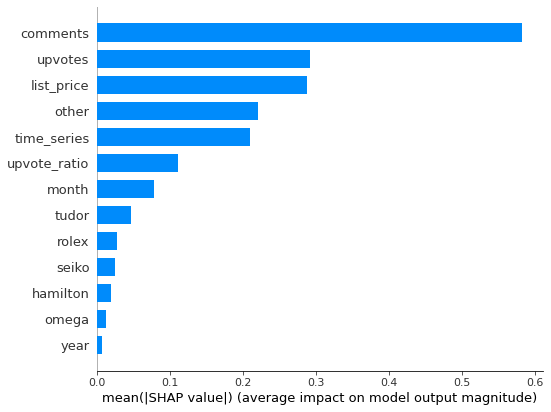

In [29]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

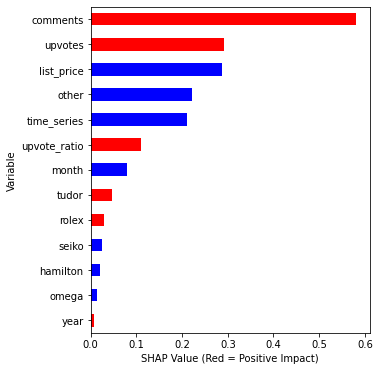

In [30]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train) 

From the SHAP value we see that the amount of comments and upvotes are positively correlated with the sale of a watch. From this these finds we can deduce that, intuitively, the more engagement a post has the more likely it is for a watch to sell. In addition, the third most influental feature is list price which is negatively correlated with the likelihood a watch will sell. This leads me to assume that it would be more effecient to sell lower priced watches in larger volume when selling on the subreddit.